# Predicting Survival on the Titanic

**_Note! Work in Progress - This notebook is not yet finished_**

An implementation in Python of the exploration of the Titanic dataset that closely follows the excellent *Exploring Survival on the Titanic* notebook by Megan L. Risdal found at https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic/notebook. Data preprocessing largely follows what she did though predictive modeling attempts to explore more models than just the random forest she used.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics

## The Dataset

In [3]:
train = pd.read_csv("train.csv", index_col='PassengerId')
test = pd.read_csv("test.csv", index_col='PassengerId')
train.head(3)
test.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [4]:
# print(train.shape)
# print(test.shape)
print('Number of features: {}'.format(test.shape[1]))
print('Training samples: {}'.format(train.shape[0]))
print('Test samples: {}'.format(test.shape[0]))
print('Total number of samples: {}'.format(train.shape[0]+test.shape[0]))

Number of features: 10
Training samples: 891
Test samples: 418
Total number of samples: 1309


The data contains the following features:

- PassengerId - a number describing a unique passenger
- Survived - the binary dependent variable indicating whether a passenger survived (1) or died (0)
- Pclass - the passenger's class, from first class (1) to third class (3)
- Name
- Sex
- Age
- SibSp - the number of siblings or spouses aboard
- Parch - the number of parents aboard
- Ticket - the ticket number
- Fare - the fare that the passenger paid
- Cabin - the cabin number the passenger stayed in
- Embarked - the port where the passenger embarked, whether at Cherbourg (C), Queenstown (Q), or Southampton (S)

It's time to explore the dataset to get a general idea of what it's like.

## Exploratory Data Analysis

We first do some general overviews of the data via summary statistics and histograms before moving on to preprocessing.

In [5]:
# First, combine datasets
total = pd.concat([train, test])

# View summary statistics
total.describe()

C:\Users\Justin\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Age,Fare,Parch,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,2.000000,0.000000,NaN
50%,NaN,NaN,0.000000,3.000000,0.000000,NaN
75%,NaN,NaN,0.000000,3.000000,1.000000,NaN
max,80.000000,512.329200,9.000000,3.000000,8.000000,1.000000


Most numerical data appear to be fairly complete, with the exception of fare (which only has one missing value) and age (which has 263 missing values). We can deal with the missing values later.

Let's also visualize the data with histograms to see the general distribution of the data.

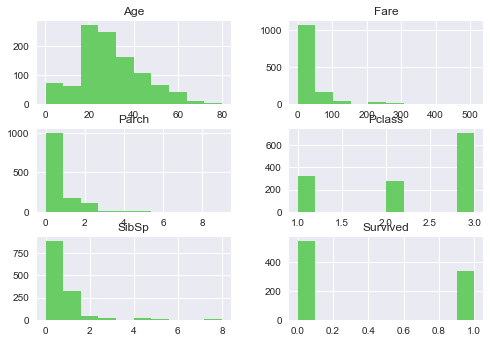

In [7]:
# Generate histograms
sns.set_color_codes('muted')
total.hist(color='g')
plt.show()

A fairly obvious observation here is that the PassengerId variable is not very useful -- we should drop this column. The rest of the data is quite interesting, with most passengers being somewhat young (around 20 to 30 years of age) and most people traveling without too much family.

Pclass serves as a proxy for the passengers' socioeconomic stata. Interestingly, the middle class appears to be the lowest in size, though not by much compared to upperclass passengers.

Looking at the data, given that we don't have  the ticket number does not appear to be too informative.

## Data Preprocessing

The first thing we should do is drop columns that will not be particularly helpful in our analysis. This includes the Ticket variable identified previously.

In [262]:
total.drop('Ticket', axis=1, inplace=True)

### Feature Engineering

A number of the variables in the data present opportunities to be further generate meaningful features. One particular feature that appears to contain a lot of meaning is the names of the passengers. As in the notebook of Megan, we will be able to extract titles (which are indicative of both gender and marriage status) and families (given by shared surnames, under the assumption that incidences of unrelated people having the same surname are trivial).

In [272]:
Surnames = pd.DataFrame(total['Name'].str.split(",").tolist(), columns=['Surname', 'Rest'])
Titles = pd.DataFrame(Surnames['Rest'].str.split(".").tolist(), columns=['Title', 'Rest1', 'Rest2'])

Surnames.drop('Rest',axis=1,inplace=True)
Titles = pd.DataFrame(Titles['Title'])

Surnames['Surname'].str.strip()
Titles['Title'].str.strip()

total['Surname'] = Surnames.set_index(np.arange(1,1310))
total['Title'] = Titles.set_index(np.arange(1,1310))

total.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Surname,Title
PassengerId,,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,Braund,Mr
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,Cumings,Mrs
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,Heikkinen,Miss
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,Futrelle,Mrs
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,Allen,Mr


Let's tabulate our titles against sex to see the frequency of the various titles.

In [264]:
pd.crosstab(total['Sex'], total['Title'])

Title,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,,
female,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1
male,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0


We see that with the exception of Master, Mr, Miss, and Mrs, the other titles are relatively rare. We can group rare titles together to simplify our analysis. Also note that Mlle and Ms are synonymous with Miss, and Mme is synonymous with Mrs.

In [278]:
raretitles = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

total.ix[total['Title'].str.contains('Mlle|Ms|Miss'), 'Title'] = 'Miss'
total.ix[total['Title'].str.contains('Mme|Mrs'), 'Title'] = 'Mrs'
total.ix[total['Title'].str.contains('|'.join(raretitles)), 'Title'] = 'Rare Title'

pd.crosstab(total['Sex'], total['Title'])

Title,Master,Mr,Miss,Mrs,Rare Title
Sex,,,,,
female,0,0,264,198,4
male,61,757,0,0,25


875

**_Note! Work in Progress - This notebook is not yet finished_**